# Trénovanie modelu iba na základe DST indexu 12h dopredu 6 dozadu
Súbor: 3_model_lstm_iba_dst.ipynb

Program: Hospodárska informatika

Vypracovala: Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

### Kontrola kapacity servera

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Import knižníc

In [3]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report

2022-10-23 19:53:59.883917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-23 19:53:59.883965: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-23 19:53:59.919762: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-23 19:54:00.663783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-23 19:54:00.663882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [4]:
df = pd.read_csv('omni_full.csv')
len(df)

520443

In [5]:
df.columns

Index(['Unnamed: 0', 'time1', 'Rot$', 'IMF', 'PLS', 'IMF_PTS', 'PLS_PTS',
       'ABS_B', 'F', 'THETA_AV', 'PHI_AV', 'BX_GSE', 'BY_GSE', 'BZ_GSE',
       'BY_GSM', 'BZ_GSM', 'SIGMA$ABS_B', 'SIGMA$B', 'SIGMA$Bx', 'SIGMA$By',
       'SIGMA$Bz', 'T', 'N', 'V', 'PHI$V', 'THETA$V', 'Ratio', 'Pressure',
       'SIGMA$T', 'SIGMA$N', 'SIGMA$V', 'SIGMA$PHI$V', 'SIGMA$THETA$V',
       'SIGMA$ratio', 'E', 'Beta', 'Mach_num', 'Mgs_mach_num', 'PR$FLX_1',
       'PR$FLX_2', 'PR$FLX_4', 'PR$FLX_10', 'PR$FLX_30', 'PR$FLX_60', 'MFLX',
       'R', 'F10_INDEX', 'KP', 'DST', 'AE', 'AP_INDEX', 'AL_INDEX', 'AU_INDEX',
       'PC_N_INDEX', 'Solar_Lyman_alpha', 'Proton_QI', 'DST+1', 'DST+2',
       'DST+3', 'DST+4', 'DST+6', 'DST+8', 'DST+12', 'DST+24'],
      dtype='object')

In [6]:
features = ['time1',
           'DST',
            'DST+12']

In [7]:
df = df[features]

In [8]:
df['time1']=pd.to_datetime(df['time1'])

In [9]:
df.dropna(inplace=True)
print(len(df))

520431


In [10]:
predicted_label = 'DST+12'

In [11]:
df.describe()

,DST,DST+12
count,520431.000000,520431.000000
mean,-14.125225,-14.125490
std,22.035041,22.034859
min,-589.000000,-589.000000
25%,-22.000000,-22.000000
50%,-10.000000,-10.000000
75%,-1.000000,-1.000000
max,81.000000,81.000000


In [12]:
df[predicted_label].describe()

count    520431.000000
mean        -14.125490
std          22.034859
min        -589.000000
25%         -22.000000
50%         -10.000000
75%          -1.000000
max          81.000000
Name: DST+12, dtype: float64

In [13]:
df.head()

,time1,DST,DST+12
12,1963-01-01 13:00:00,-8.0,-5.0
13,1963-01-01 14:00:00,-6.0,-5.0
14,1963-01-01 15:00:00,-11.0,-3.0
15,1963-01-01 16:00:00,-17.0,-3.0
16,1963-01-01 17:00:00,-16.0,-6.0


<AxesSubplot:>

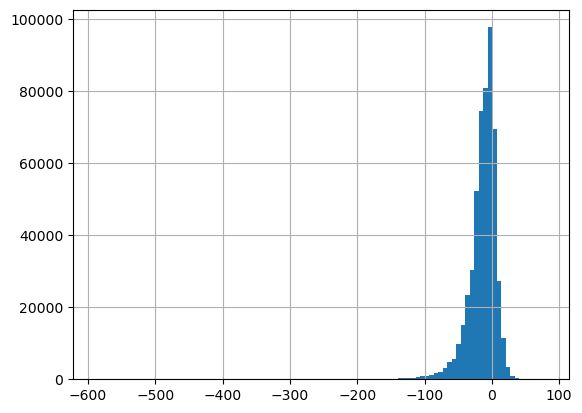

In [14]:
df[predicted_label].hist(bins=100)

In [15]:
# transform label using sigmoid
variance = df[predicted_label].std()
df["contcontinuous_transforminuous_transform"] = df[predicted_label].apply(lambda x: expit(2 * ((x - 0.2) / variance)))
df["contcontinuous_transforminuous_transform"].describe()

count    5.204310e+05
mean     3.113632e-01
std      2.271177e-01
min      5.948525e-24
25%      1.176381e-01
50%      2.837764e-01
75%      4.727973e-01
max      9.993474e-01
Name: contcontinuous_transforminuous_transform, dtype: float64

In [16]:
# choose one of them
# define y variable, i.e., what we want to predict

y_col='DST+12'
#y_col='contcontinuous_transforminuous_transform'

In [17]:
# train-test division

test_size = int(len(df) * 0.2) # here I ask that the test data will be 20% of the entire data
train = df.iloc[:-test_size,:].copy()
test = df.iloc[-test_size:,:].copy()

In [18]:
# train-validation division

valid_size = int(len(train) * 0.2) # here I ask that the test data will be 15% of the entire data
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

In [19]:
# separate features and labels

y_train = train[y_col].values.copy()
X_train = train['DST'].values.copy()

y_val = valid[y_col].values.copy()
X_val = valid['DST'].values.copy()

y_test = test[y_col].values.copy()
X_test = test['DST'].values.copy()

In [20]:
print(y_test[0:40])

[ -5.  -6.  -6.  -5.  -4.  -7.  -9.  -9. -12. -13. -13. -12. -12. -17.
 -17. -15. -11.  -8. -12. -16. -14. -14. -14. -15. -17. -13. -15. -24.
 -21. -17. -15. -17. -25. -27. -26. -27. -27. -25. -26. -20.]


In [21]:
len(y_test)

104086

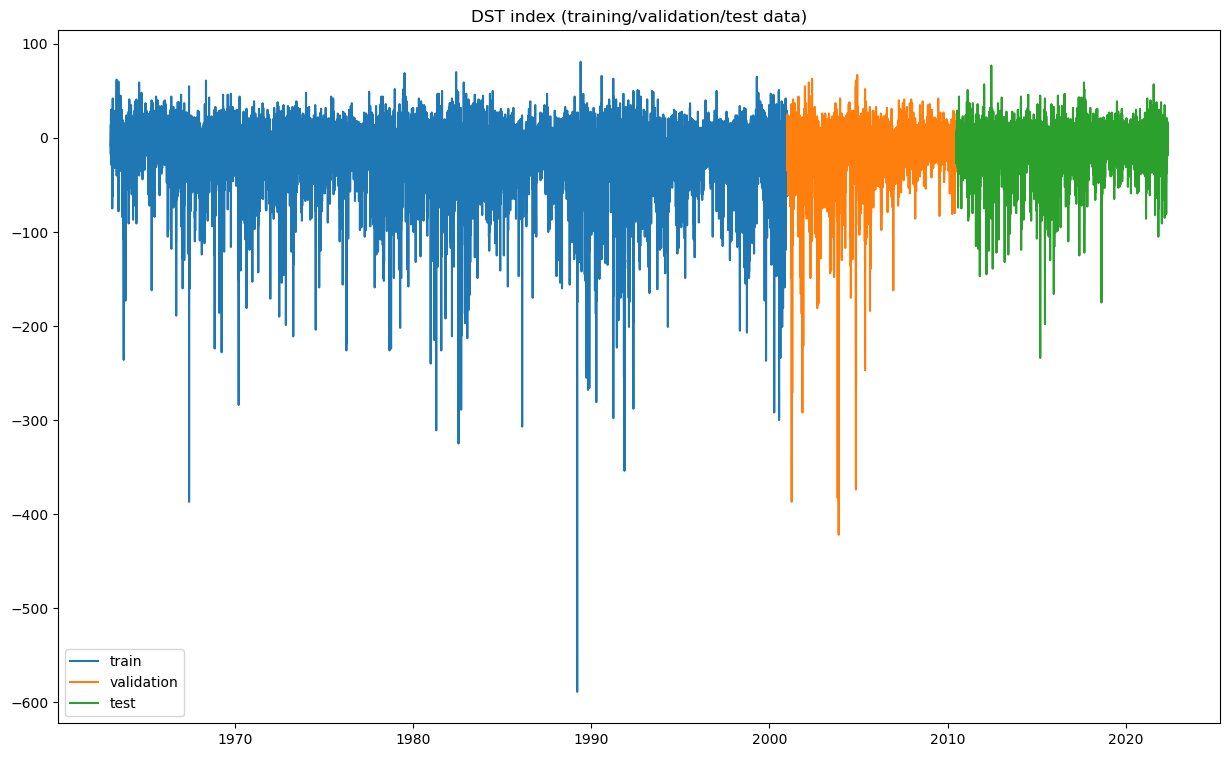

In [22]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [23]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [24]:
for i in range(len(test_generator)):
	x, y = test_generator[i]
	print('tt %s => %s' % (x, y))

tt [[-12. -17. -17. -15. -11.  -8.]
 [-17. -17. -15. -11.  -8. -12.]
 [-17. -15. -11.  -8. -12. -16.]
 ...
 [ -2.  -3.  -5.  -6.  -4.  -5.]
 [ -3.  -5.  -6.  -4.  -5.  -8.]
 [ -5.  -6.  -4.  -5.  -8. -10.]] => [ -9.  -9. -12. -13. -13. -12. -12. -17. -17. -15. -11.  -8. -12. -16.
 -14. -14. -14. -15. -17. -13. -15. -24. -21. -17. -15. -17. -25. -27.
 -26. -27. -27. -25. -26. -20. -16. -14. -14. -16. -16. -15. -13. -10.
 -15. -18. -21. -22. -18. -14. -15. -18. -19. -19. -16. -16. -17. -17.
 -15. -18. -15. -13. -12. -10. -14. -16. -16. -12. -10.  -9.  -9. -13.
 -17. -16. -21. -21. -19. -19. -17. -17. -19. -18. -19. -18. -16. -16.
 -16. -16. -14. -11.  -7.  -6. -11. -19. -22. -21. -18. -15. -13. -15.
 -13. -13. -12. -12.  -9. -10. -11. -14. -13. -12.  -8.  -4.  -1.  -1.
  -1.  -4.  -6.  -9. -12. -12. -15. -19. -21. -18. -16. -12. -12. -11.
 -12. -15. -17. -17. -15. -14. -13.  -9.  -8.  -9.  -9.  -8.  -5.  -3.
  -5.  -7.  -9. -12. -10. -11. -12. -11.  -9.  -9.  -8.  -9. -11. -10.
  -8.  -3

In [25]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1302
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [26]:
inputs = Input(shape=(n_input,1))
b = Conv1D(128, kernel_size = 4, padding = "same")(inputs)
b = Bidirectional(LSTM(128, dropout=0.1,recurrent_dropout=0.1))(inputs)
b = Dense(64, activation='relu')(b)
b = Dropout(0.2)(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2022-10-23 19:54:14.213377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-23 19:54:14.213428: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-23 19:54:14.213466: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              133120    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                             

In [27]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 256)           133120    
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 7   

In [28]:
# callbacks
saved_model = "6_dozadu_12_dopredu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [29]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20
1302/1302 [==============================] - ETA: 0s - loss: 209.5972 - mae: 8.9256
Epoch 1: val_mae improved from inf to 7.41104, saving model to 6_dozadu_12_dopredu.hdf5
1302/1302 [==============================] - 111s 81ms/step - loss: 209.5972 - mae: 8.9256 - val_loss: 160.9345 - val_mae: 7.4110
Epoch 2/20
1302/1302 [==============================] - ETA: 0s - loss: 180.2527 - mae: 8.5050
Epoch 2: val_mae did not improve from 7.41104
1302/1302 [==============================] - 182s 140ms/step - loss: 180.2527 - mae: 8.5050 - val_loss: 165.9971 - val_mae: 7.5032
Epoch 3/20
1302/1302 [==============================] - ETA: 0s - loss: 175.9256 - mae: 8.4201
Epoch 3: val_mae improved from 7.41104 to 7.40440, saving model to 6_dozadu_12_dopredu.hdf5
1302/1302 [==============================] - 187s 144ms/step - loss: 175.9256 - mae: 8.4201 - val_loss: 154.7677 - val_mae: 7.4044
Epoch 4/20
1302/1302 [==============================] - ETA: 0s - loss: 174.1524 - mae: 8.3913
Ep

In [30]:
# load best model
model = keras.models.load_model('6_dozadu_12_dopredu.hdf5')

In [31]:
# prediction
y_pred = model.predict(test_generator)

407/407 [==============================] - 19s 43ms/step


In [32]:
y_pred

array([[-10.745328 ],
       [-16.026188 ],
       [-16.718086 ],
       ...,
       [  6.711553 ],
       [  4.6437416],
       [  3.9369643]], dtype=float32)

In [33]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[78075  5289]
 [ 6107 14609]]


In [34]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     83364
           1       0.73      0.71      0.72     20716

    accuracy                           0.89    104080
   macro avg       0.83      0.82      0.83    104080
weighted avg       0.89      0.89      0.89    104080



In [35]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [36]:
df

,time,y_true,y_predict
416363,2010-06-29 13:00:00,-9.0,-10.745328
416364,2010-06-29 14:00:00,-9.0,-16.026188
416365,2010-06-29 15:00:00,-12.0,-16.718086
416366,2010-06-29 16:00:00,-13.0,-15.525084
416367,2010-06-29 17:00:00,-13.0,-13.999883
...,...,...,...
520438,2022-05-13 12:00:00,8.0,6.475840
520439,2022-05-13 13:00:00,13.0,4.568148
520440,2022-05-13 14:00:00,16.0,6.711553
520441,2022-05-13 15:00:00,15.0,4.643742


In [37]:
df.describe()

,y_true,y_predict
count,104080.000000,104080.000000
mean,-9.642909,-10.364395
std,16.039383,14.150689
min,-234.000000,-156.959091
25%,-17.000000,-16.804445
50%,-7.000000,-7.624387
75%,0.000000,-0.844299
max,77.000000,19.977074


<AxesSubplot:>

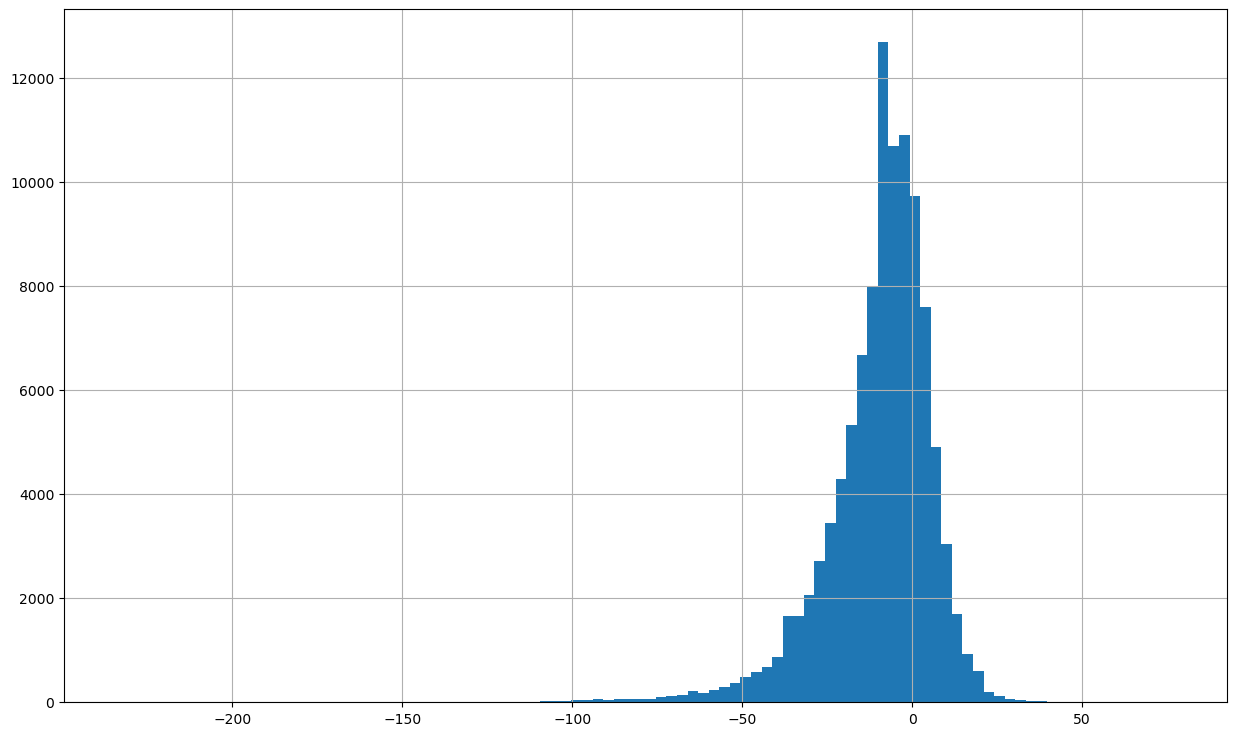

In [38]:
df["y_true"].hist(bins=100)

<AxesSubplot:>

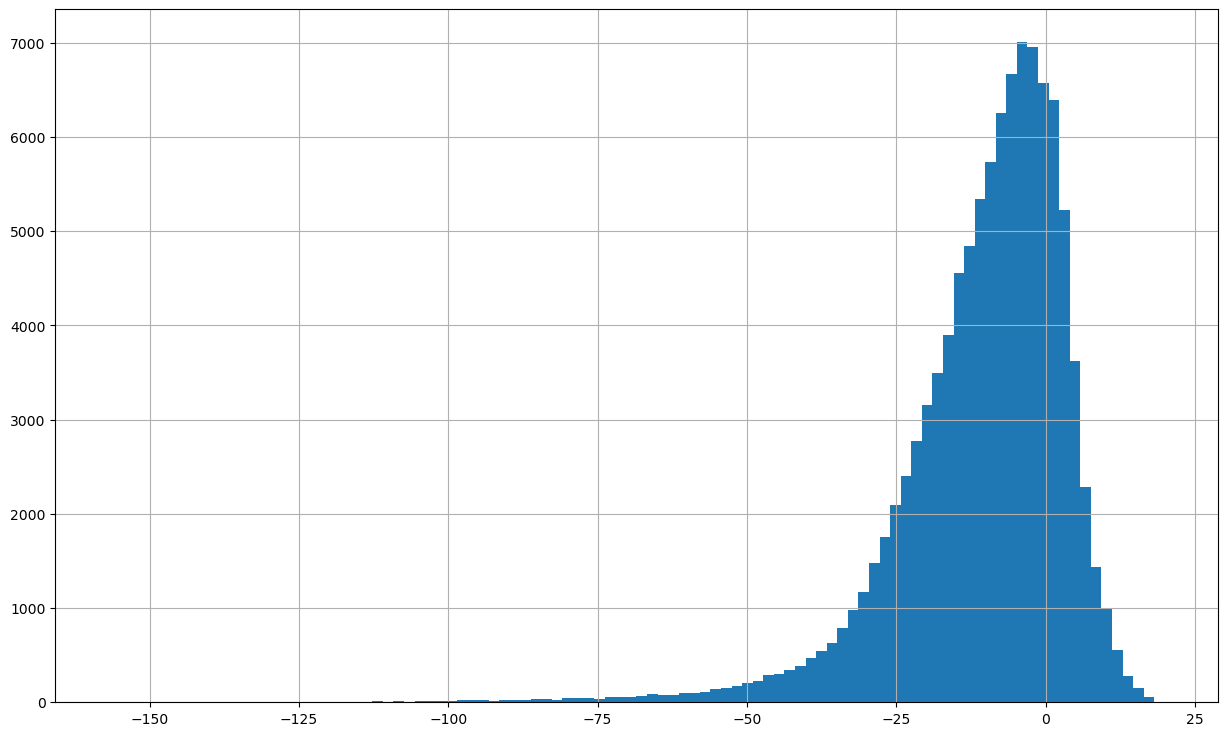

In [39]:
df["y_predict"].hist(bins=100)

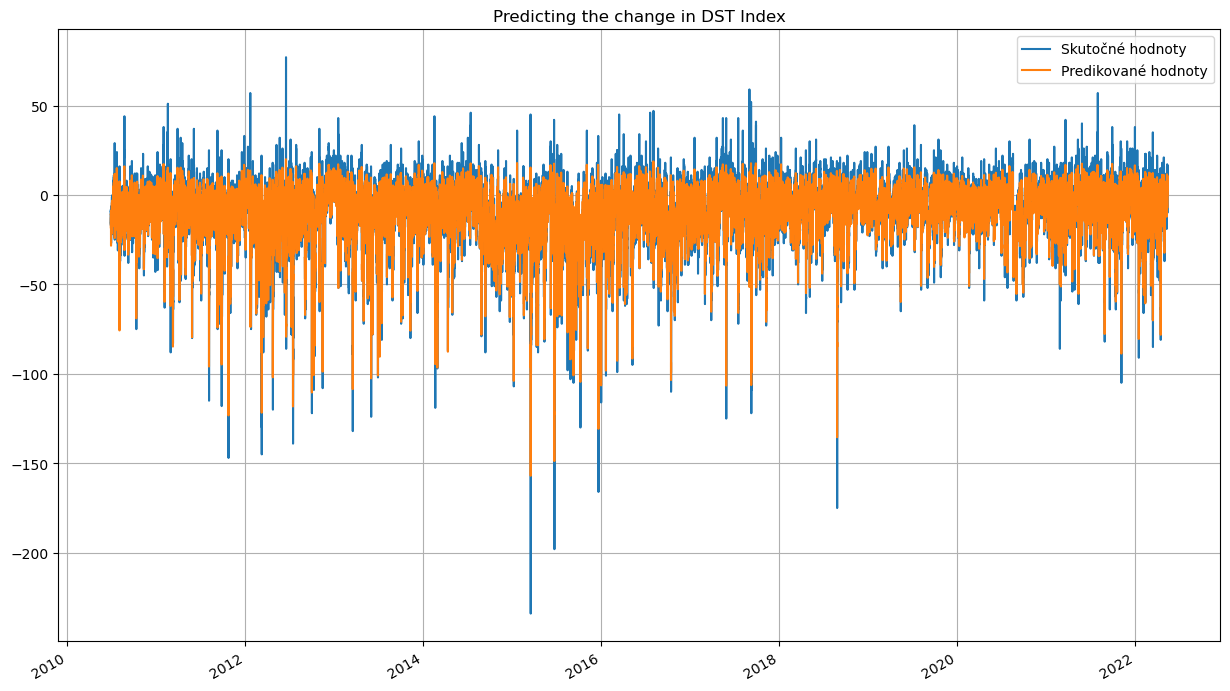

In [40]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [41]:
df.to_csv('predikcie_6h_dozadu_12h_dopredu.csv')